<a href="https://colab.research.google.com/github/VladKarad/AI_education/blob/main/Mnist_Autoencoder_architecture_HW_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Добейтесь на автокодировщике с 2-мерным скрытым пространством на 3-х цифрах: 0, 1 и 3 – ошибки MSE**<0.034** на скорости обучения **0.001** на **10-й эпохе**.

## Импорт библиотек


In [ ]:
# Работа с операционной системой
import os

# Отрисовка графиков
import matplotlib.pyplot as plt 

# Операции с путями
import glob

# Работа с массивами данных
import numpy as np

# Слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Concatenate

# Модель
from tensorflow.keras import Model

# Загрузка модели
from tensorflow.keras.models import load_model

# Датасет
from tensorflow.keras.datasets import mnist

# Оптимизатор для обучения модели
from tensorflow.keras.optimizers import Adam

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

%matplotlib inline

## Утилиты

Функция-коллбэк. Отрисовывает объекты в скрытом пространстве

In [ ]:
def ae_on_epoch_end(epoch, logs):
    print('________________________')  
    print(f'*** ЭПОХА: {epoch+1}, loss: {logs["loss"]} ***')
    print('________________________')  
    
    # Получение картинки латентного пространства в конце эпохи и запись в файл
    # Задание числа пикселей на дюйм
    plt.figure(dpi=100)

    # Предсказание енкодера на тренировочной выборке
    predict = encoder.predict(X_train)

    # Создание рисунка: множество точек на плоскости 3-х цветов (3-х классов)
    scatter = plt.scatter(predict[:,0,],predict[:,1], c=y_train, alpha=0.6, s=5)

    # Создание легенды
    legend2 = plt.legend(*scatter.legend_elements(), loc='upper right', title='Классы')

    # Сохранение картинки с названием, которого еще нет
    paths = glob.glob('*.jpg')
    plt.savefig(f'image_{str(len(paths))}.jpg')

    # Отображение. Без него рисунок не отрисуется
    plt.show()


ae_callback = LambdaCallback(on_epoch_end=ae_on_epoch_end)

Удаление изображений. Применять при обучении новой модели, чтобы не было путаницы в картинках.

In [ ]:
def clean():
  # Получение названий всех картинок
  paths = glob.glob('*.jpg')

  # Удаление всех картинок по полученным путям
  for p in paths:
    os.remove(p)

# Удаление всех картинок
clean()

## Загрузка данных

In [ ]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Нормировка
X_train = X_train.astype('float32')/255.
X_train = X_train.reshape(-1, 28, 28, 1)

In [ ]:
# Выбор визуализируемых классов (цифр) и формирование подвыборок для них по маске
numbers = [0, 1, 3]
mask = np.array([(i in numbers) for i in y_train])
X_train = X_train[mask]
y_train = y_train[mask]

In [ ]:
X_train.shape

(18796, 28, 28, 1)

In [ ]:
X_train.shape[1:4]

(28, 28, 1)

## Создание модели и обучение

In [ ]:
##################################################
###         Место для вашей модели             ###
##################################################



In [ ]:
# Функция сборки автокодировщика по частям
def create_dense_ae(in_shape, latent_dim): 
    # ЭНКОДЕР
    # Вход
    a_a = X_train.shape[1:4]   
    input_img = Input(in_shape)
    input_img = Reshape(a_a)(input_img)

    input_img1 = Conv2D(12, 3, padding='same', activation='relu')(input_img)
    input_img2 = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(input_img1)
    input_img3 = Conv2D(32, 3, padding='same', strides=2)(input_img2)
    input_img4 = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(input_img3)

    input_img5 = Conv2D(1, 2, padding='same', activation='relu')(input_img4)
    

     # Вспомогательный слой смены формы
    flat_img = Flatten()(input_img5)    
    
    
   
    #flat_img = Dense(784, activation='relu')(flat_img)
    #flat_img = Dropout(0.4)(flat_img)    
    flat_img = Dense(10, activation='relu')(flat_img)
    #flat_img = Dense(10, activation='relu')(flat_img)
    #flat_img = Dense(70, activation='relu')(flat_img)

    # Кодированное полносвязным слоем представление (вектор латентного пространства)
    encoded = Dense(latent_dim, activation='relu')(flat_img)    

    # ДЕКОДЕР
    # Вход
    input_encoded = Input(shape=(latent_dim,))

    # Раскодированное другим полносвязным слоем изображение в виде плоского вектора
    flat_decoded = Dense(in_shape[0] * in_shape[1], activation='sigmoid')(input_encoded) 
    
    # Приведение формы раскодированных данных к форме входа
    decoded = Reshape(in_shape)(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать, как и слои
    encoder = Model(input_img, encoded, name='encoder')
    decoder = Model(input_encoded, decoded, name='decoder')

    # Построение модели автокодировщика (внутри двойное преобразование - сжатие/разжатие)
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

    # Возврат трех собранных моделей
    return encoder, decoder, autoencoder

In [ ]:
 #Создание трех моделей - составных частей автокодировщика и самого автокодировщика
encoder, decoder, autoencoder = create_dense_ae(in_shape=X_train.shape[1:3], latent_dim=2)

In [ ]:
# Функции-утилиты
from tensorflow.keras import utils

Схема энкодера:


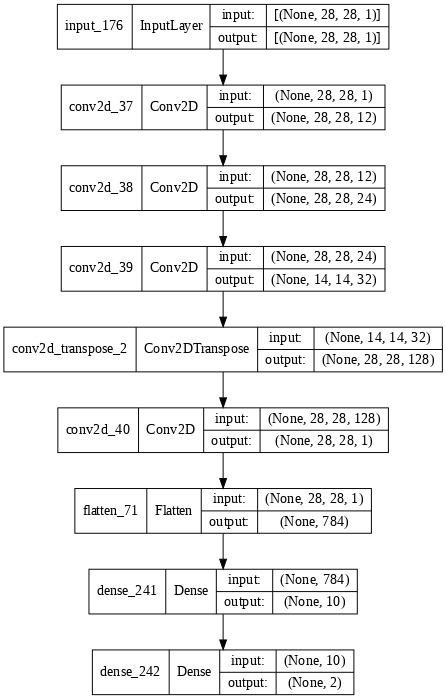

In [ ]:
print('Схема энкодера:')
utils.plot_model(encoder, show_shapes=True, dpi=70)

________________________
*** ЭПОХА: 1, loss: 0.1749841719865799 ***
________________________


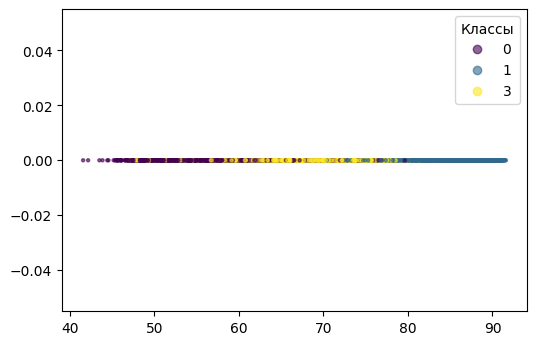

________________________
*** ЭПОХА: 2, loss: 0.0625011995434761 ***
________________________


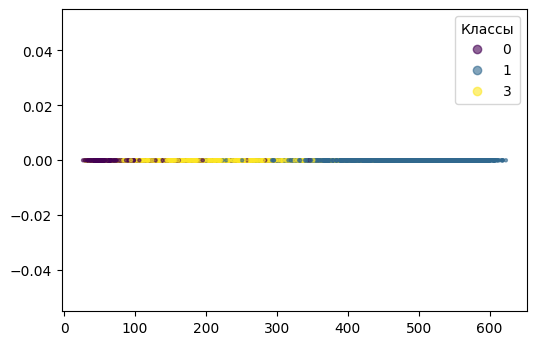

________________________
*** ЭПОХА: 3, loss: 0.05757446214556694 ***
________________________


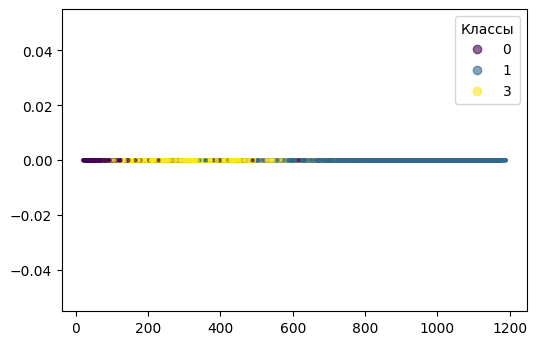

________________________
*** ЭПОХА: 4, loss: 0.05648765340447426 ***
________________________


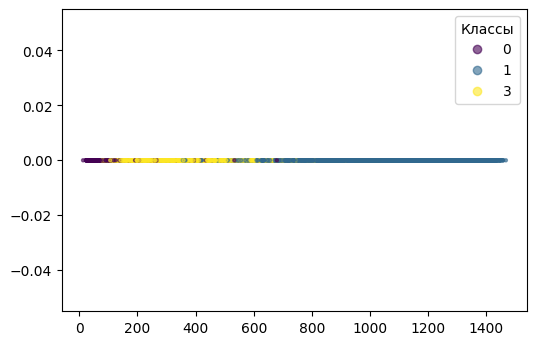

________________________
*** ЭПОХА: 5, loss: 0.05586216226220131 ***
________________________


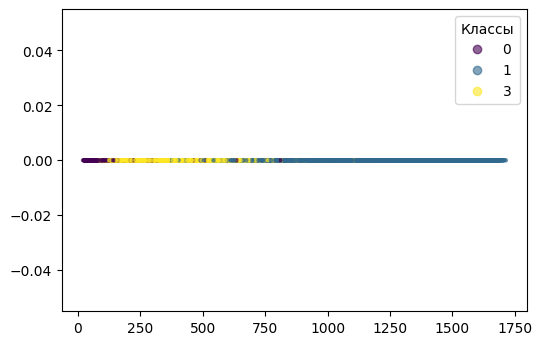

________________________
*** ЭПОХА: 6, loss: 0.05521516501903534 ***
________________________


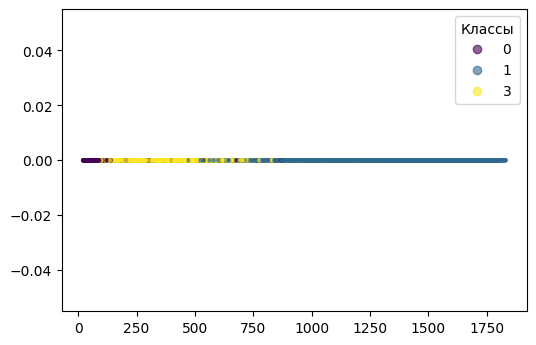

________________________
*** ЭПОХА: 7, loss: 0.05475131422281265 ***
________________________


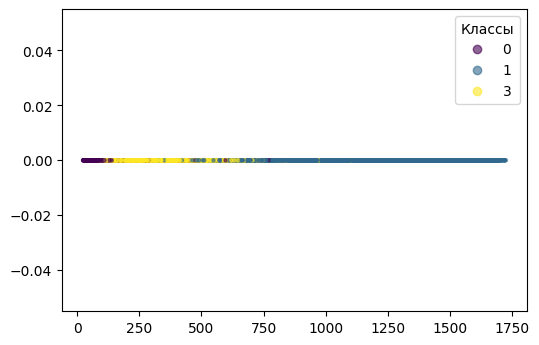

________________________
*** ЭПОХА: 8, loss: 0.05436325445771217 ***
________________________


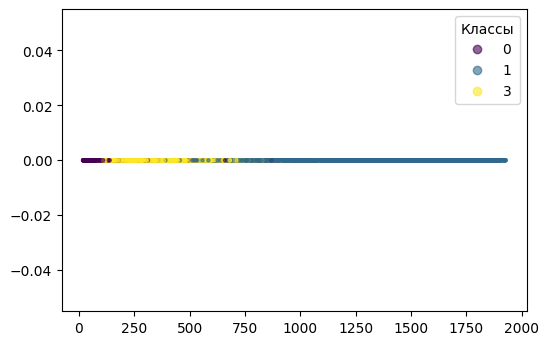

________________________
*** ЭПОХА: 9, loss: 0.054032981395721436 ***
________________________


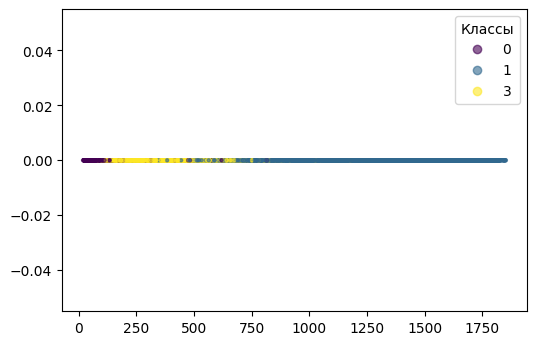

________________________
*** ЭПОХА: 10, loss: 0.05366820469498634 ***
________________________


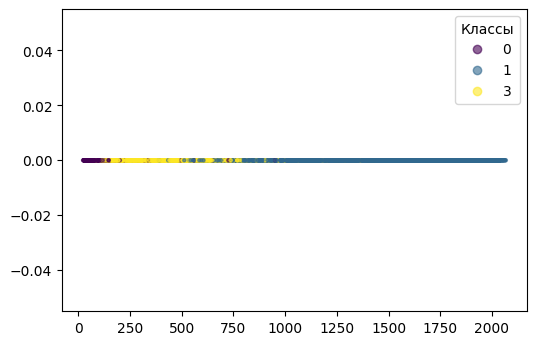

In [ ]:
# Компиляция модели с выбранным оптимизатором и функцией потерь 
autoencoder.compile(optimizer=Adam(learning_rate=0.001),  loss='mse') 



epochs = 10

# Обучение автокодировщика с протоколом работы
autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                callbacks = [ae_callback],
                verbose=0)

In [ ]:
import imageio                            # Подключение библиотеки для сборки анимации
images = []                               # Пустой список под изображения для gif
for i in range(epochs):                   # Покадровая сборка gif-анимации
    images.append(imageio.imread(f'image_{str(i)}.jpg')) 
imageio.mimsave('AE.gif', images)         # Сохранение анимации

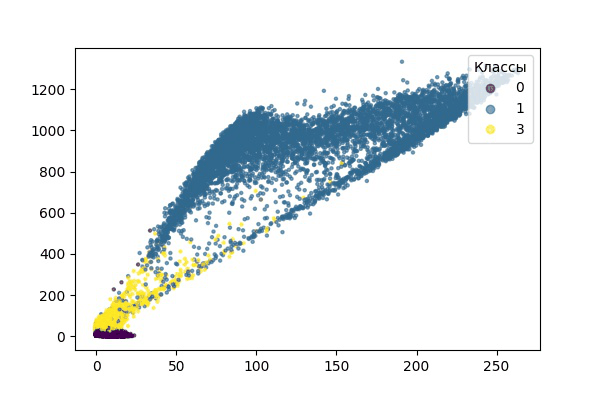

In [ ]:
from IPython.display import Image         # Подключаем модуля для показа gif в ячейке
Image(open('AE.gif','rb').read())         # Показ анимации